# Time series modeling

files needed = ( none )

We continue to work with the statsmodels package [(docs)](https://devdocs.io/statsmodels/). This notebook is a brief introduction to the time series methods. 

We are only going to touch on autoregressive models here, but statsmodels [tsa](https://www.statsmodels.org/dev/tsa.html) package has support for moving average and ARIMA models as well as vector autoregression and error correction models. The package also includes filtering methods and time series related plotting functions. 

Time series models are often used for forecasting. If forecasting interests you, Prof. Hansen offers a [forecasting course](https://www.ssc.wisc.edu/~bhansen/460/) (ECON 460) where you can learn a lot more about these kinds of models.

In [56]:
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting
import seaborn as sea                  # advanced plotting

import statsmodels.graphics.tsaplots as tsaplots  # Gives the the autocorrelation plot
import statsmodels.tsa as tsa                     # The time series models

from pandas_datareader import data, wb    # we are grabbing the data and wb functions from the package
import datetime as dt                     # for time and date

### GDP 

Let's model US GDP as an autoregressive process. Grab the data from FRED.

In [57]:
codes = ['GDPC1']  # The code for real GDP at FRED.
start = dt.datetime(1947, 1, 1)

usa = data.DataReader(codes, 'fred', start)
usa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 287 entries, 1947-01-01 to 2018-07-01
Data columns (total 1 columns):
GDPC1    287 non-null float64
dtypes: float64(1)
memory usage: 4.5 KB


In [58]:
usa.rename(columns={'GDPC1':'gdp'}, inplace=True)

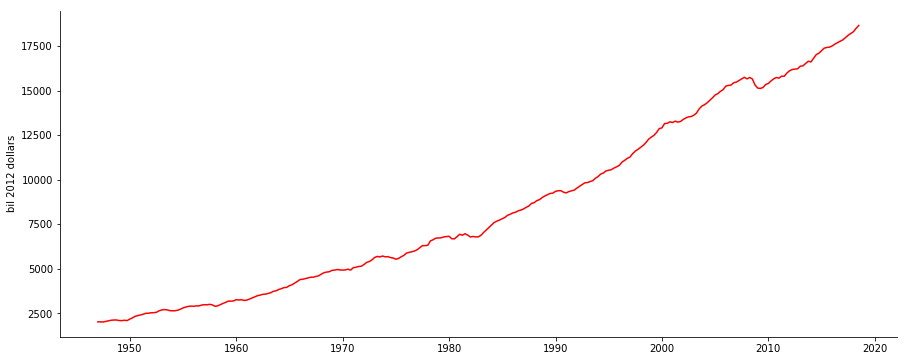

In [59]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(usa.index, usa['gdp'], color = 'red')
ax.set_ylabel('bil 2012 dollars')

sea.despine(ax=ax)

plt.show()

### Stationarity

The GDP data are not stationary --- there is clearly a trend. Autoregressive models are usually used on stationary data. We can filter the data to remove the trend and recover a stationary series (tsa has [methods](https://www.statsmodels.org/dev/tsa.html#time-series-filters) to to this), but GDP is usually stationary in growth rates. 

Compute the growth rate of the GDP data.

In [60]:
# The log-difference is a close approximation of the growth rate when growth rates are small. 
# log-differences are often used in practice because they are symmetric. 

usa['gdp_diff'] = np.log(usa['gdp']) - np.log(usa['gdp'].shift(1))
usa['gdp_pct'] = usa['gdp'].pct_change()
usa.head()

,gdp,gdp_diff,gdp_pct
DATE,,,
1947-01-01,2033.061,NaN,NaN
1947-04-01,2027.639,-0.002670,-0.002667
1947-07-01,2023.452,-0.002067,-0.002065
1947-10-01,2055.103,0.015521,0.015642
1948-01-01,2086.017,0.014931,0.015043


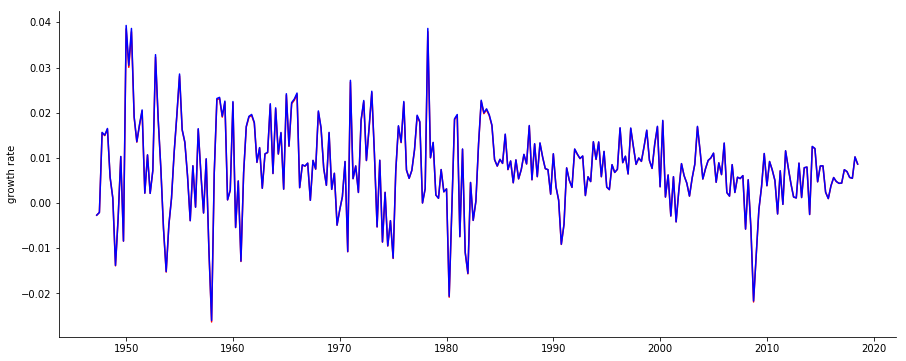

In [61]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(usa.index, usa['gdp_diff'], color = 'red')
ax.plot(usa.index, usa['gdp_pct'], color = 'blue')

ax.set_ylabel('growth rate')

sea.despine(ax=ax)

plt.show()

This looks roughly stationary.  There are things like Dickey-Fuller tests for stationarity (again, these can be done in statsmodels) but they are outside of the scope of this notebook. 

### Autoregressive model 

We say [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) because we are modeling the variable as a function of its past values. The general model is

$$ y_t = \varphi_0 + \varphi_1y_{t-1} + \varphi_2 y_{t-2} + \cdots + \varphi_p y_{t-p}+\epsilon_t.$$

This model has $p$ lags. We refer to it as an AR(p) model or an autoregressive model of order $p$. 

Determining the number of lags to include is part of specifying the model.


Let's start by looking at the data to see if it has an autoregressive property. Is there a relationship between the current value of GDP growth and its past value?

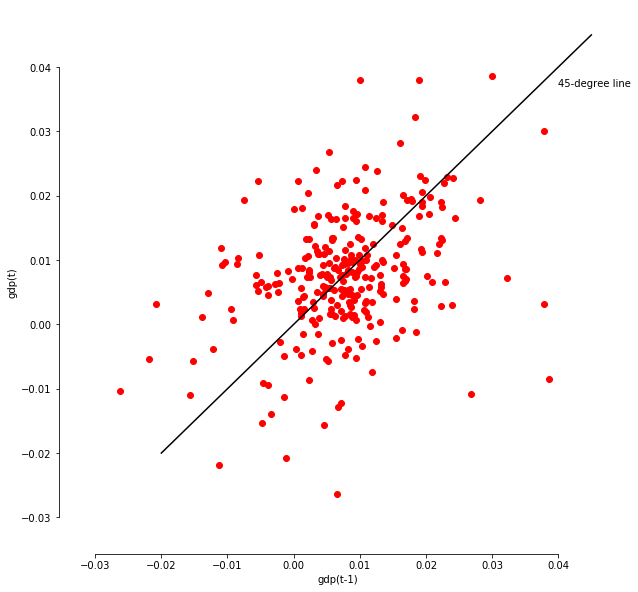

In [62]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(usa['gdp_diff'], usa['gdp_diff'].shift(1), color = 'red')

# plot the 45 degree line
ax.plot([-0.02, 0.045], [-0.02, 0.045], color='black')

ax.text(0.04, 0.037, '45-degree line')

ax.set_ylabel('gdp(t)')
ax.set_xlabel('gdp(t-1)')

sea.despine(ax=ax, trim=True)

plt.show()

There appears to be a positive relationship, but it is noisy. 

### The autocorrelation function

Our plot above tells us about the $t$ and $t-1$ relationship. How about $t$ and $t-2$? $t-5$? We could continue to make the plots above, but there are better ways. 

The autocorrelation function plots $\text{corr}(y_t, y_{t-k})$ for many values of $k$. statsmodels automates this for us with the `.plot_acf()` function [(docs)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html).  

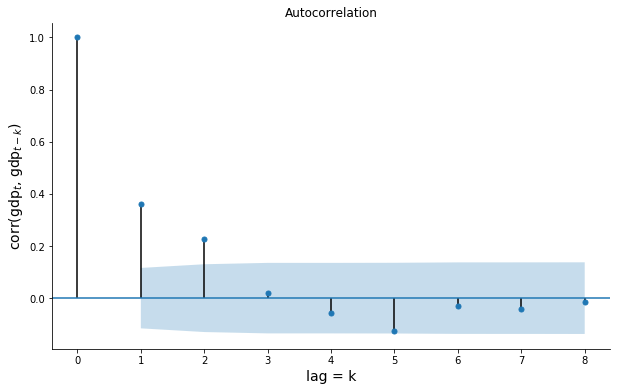

In [63]:
fig, ax = plt.subplots(figsize=(10,6))

# plot_acf is picky about nas, so drop them
# The 'lags' parameter determines how many lags to show
tsaplots.plot_acf(usa['gdp_diff'].dropna(), lags = 8, ax = ax)

ax.set_xlabel('lag = k', fontsize=14)
ax.set_ylabel(r'corr(gdp$_t$, gdp$_{t-k}$)', fontsize=14)
sea.despine(ax=ax)

plt.show()

### Estimating the AR(p) model

The AR(p) model in statsmodels works like the other models. You create a model object, then  you call the `.fit( )` method to estimate the parameters. 

The only real difference here is that you do not need to write out a string with the model specification. The `.AR( )` method knows that the model is AR(p). 

In [64]:
# I couldn't get these two methods to work. Need to look into this.
# usa = usa.asfreq('q')  
# usa.index.freq = 'q'

# Need to set the frequency of hte data. This is a not-very-elegant way. 
usa = usa.resample('q').mean()

# Construct the model. 
ar_mod = tsa.ar_model.AR(usa['gdp_diff'].dropna(), freq='Q')

type(ar_mod)  # What have we got?

statsmodels.tsa.ar_model.AR

Now we call fit [(docs)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit). 

Here we have to decide how many lags we want. There are two options to deal with. 

* ic is the criterion for choosing how many lags to include. Options are 'aic', 'bic', 'hic', and 't-stat'.Which one to choose is a technical detail. Let's  go with 'aic'. Alternatively, you can choose ic = None.
* maxlag is the maximum number of lags. If ic = None, this is the number of lags. 


In [65]:
#res = ar_mod.fit(ic = None, maxlag=3)

res = ar_mod.fit(ic = 'aic')

In [66]:
# The parameters
print(res.params)


const          0.004485
L1.gdp_diff    0.316613
L2.gdp_diff    0.112959
dtype: float64


In [67]:
# The optimal number of lags is
print('The number of lags is {0}.'.format(res.k_ar))

The number of lags is 2.


The results object has lots of stuff in it. Try tab completion to see what's in there. 

Let's plot the fitted values

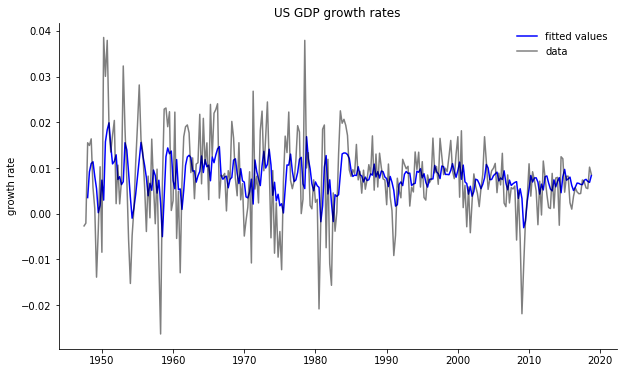

In [68]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(res.fittedvalues, color='blue', label = 'fitted values')
ax.plot(usa.index, usa.gdp_diff, color='black', alpha = 0.5, label = 'data')

sea.despine(ax=ax)
ax.set_ylabel('growth rate')
ax.set_title('US GDP growth rates')

ax.legend(frameon=False)

plt.show()

The fitted values track the data, but do not generate enough volatility. If we really wanted to get serious about modeling GDP growth, we would want to expand our model to something like an autoregressive-moving-average model.

## Practice

Take a few minutes and try the following. Feel free to chat with those around if you get stuck. The TA and I are here, too.

1. Read in the S\&P 500 price index from FRED. Use November 23, 2013 as the start date.
2. Resample the data to weekly frequency using mean().

In [69]:
fred_codes = ["SP500"]
start_sp = dt.datetime(2013, 11, 23)
sp = data.DataReader(name=fred_codes, data_source="fred", start=start_sp)
sp = sp.resample("w").mean()
sp.head()

,SP500
DATE,
2013-12-01,1804.5675
2013-12-08,1795.7960
2013-12-15,1788.8060
2013-12-22,1801.2220
2013-12-29,1836.1825


3. Plot the weekly average price. Are the data stationary?

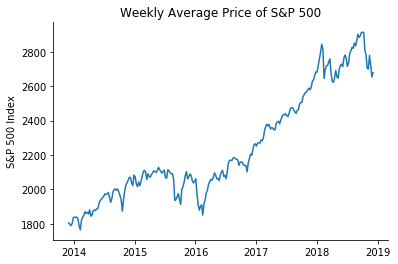

In [70]:
fig, ax = plt.subplots()

ax.plot(sp)
sea.despine(ax=ax)
ax.set_ylabel("S&P 500 Index")
ax.set_title("Weekly Average Price of S&P 500")

plt.show()

4. Compute the log difference of the weekly price data. 
5. Plot the growth rates. Are the data stationary?

In [71]:
sp["logdiff"] = np.log(sp.SP500) - np.log(sp.SP500.shift(1))
sp.head()

,SP500,logdiff
DATE,,
2013-12-01,1804.5675,NaN
2013-12-08,1795.7960,-0.004873
2013-12-15,1788.8060,-0.003900
2013-12-22,1801.2220,0.006917
2013-12-29,1836.1825,0.019223


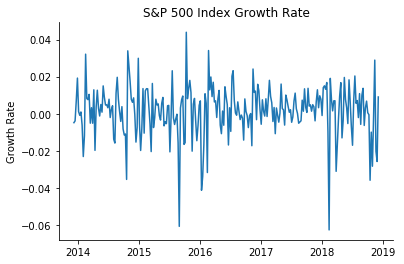

In [72]:
fig, ax = plt.subplots()

ax.plot(sp.index, sp.logdiff)
sea.despine(ax=ax)
ax.set_ylabel("Growth Rate")
ax.set_title("S&P 500 Index Growth Rate")

plt.show()

6. Plot the autocorrelation function for 20 lags. What lags look meaningful? 

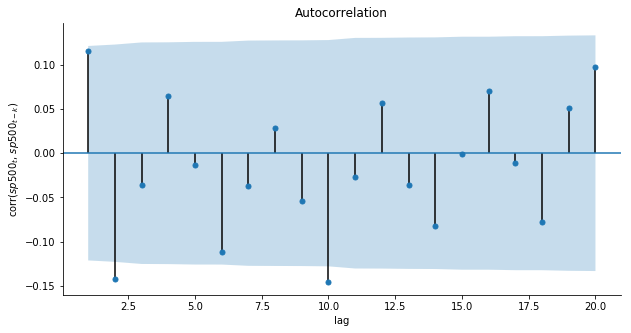

In [139]:
fig, ax = plt.subplots(figsize=(10, 5))

tsaplots.plot_acf(sp["logdiff"].dropna(), lags=20, ax=ax, zero=False)

ax.set_xlabel('lag')
ax.set_ylabel('corr($sp500_t$, $sp500_{t-k}$)')
sea.despine(ax=ax)

plt.show()

7. Estimate an AR(p) model of the price data. Include 1 lag.

In [140]:
sp_ar1 = tsa.ar_model.AR(sp.logdiff.dropna(), freq="w").fit(maxlag=1, ic=None)

8. Print out the number of lags used and the parameter estimates. 

In [141]:
print("The number of lags used is {0}".format(sp_ar1.k_ar))
print(sp_ar1.params)

The number of lags used is 1
const         0.001366
L1.logdiff    0.115247
dtype: float64


9. Plot the data and the fitted values. 

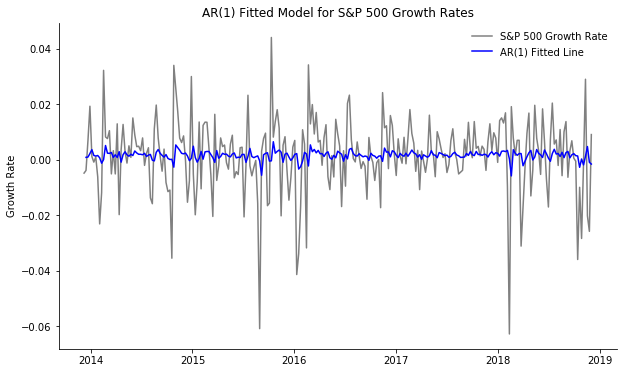

In [142]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sp.index, sp.logdiff, color="gray", label="S&P 500 Growth Rate")
ax.plot(sp_ar1.fittedvalues, color="blue", label="AR(1) Fitted Line")
sea.despine(ax=ax)
ax.legend(frameon=False)
ax.set_ylabel("Growth Rate")
ax.set_title("AR(1) Fitted Model for S&P 500 Growth Rates")

plt.show()

10. Restimate the model letting the `.fit( )` method choose the number of lags. How many lags were chosen?
11. Print out the number of lags and the parameter estimates. 

\[If you have extra time, try ploting the estimates and their confidence intervals. I used errorbar, but there are many ways.\]

In [143]:
sp_araic = tsa.ar_model.AR(sp.logdiff.dropna()).fit(ic="aic")
print("The number of lags used is {0}".format(sp_araic.k_ar))
print(sp_araic.params)

The number of lags used is 2
const         0.001612
L1.logdiff    0.133882
L2.logdiff   -0.161005
dtype: float64


In [144]:
params = sp_araic.params.reset_index()
conf = sp_araic.conf_int().reset_index()
merged = pd.merge(left=params, right=conf, on=["index"], how="outer")
merged.columns = ["index", "estimate", "lower", "upper"]
merged.set_index(keys="index", inplace=True)
merged["yerr_lower"] = merged.estimate - merged.lower
merged["yerr_upper"] = merged.upper - merged.estimate
yerr = np.array(merged.yerr_lower)
print(yerr)

[0.0016476  0.12104661 0.12195986]


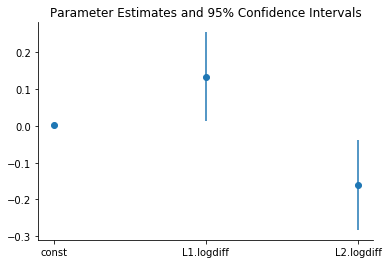

In [146]:
# Plot parameter estimates
fig, ax = plt.subplots()

ax.errorbar(x=merged.index, y=merged.estimate, yerr=yerr, ls="none", fmt="o")
sea.despine(ax=ax)
ax.set_title("Parameter Estimates and 95% Confidence Intervals")

plt.show()

In [226]:
param_ci = pd.DataFrame(sp_araic.conf_int())
y_low = param_ci.iloc[0, 0] + param_ci.iloc[1, 0]*sp.logdiff.shift(1) + param_ci.iloc[2, 0]*sp.logdiff.shift(2)
y_upp = param_ci.iloc[0, 1] + param_ci.iloc[1, 1]*sp.logdiff.shift(1) + param_ci.iloc[2, 1]*sp.logdiff.shift(2)
y_ci = pd.DataFrame({"lower":y_low.dropna(), "upper":y_upp.dropna()})
y_ci = np.array(y_ci.transpose())
y_ci.shape

(2, 258)

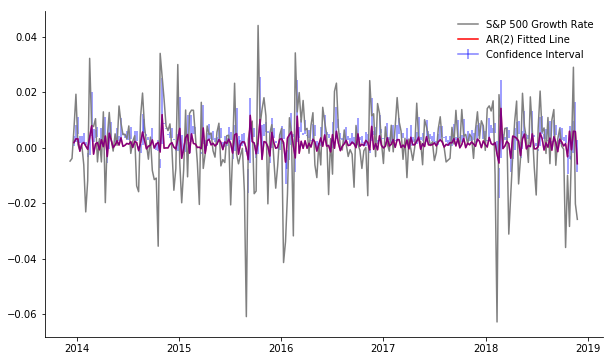

In [227]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sp.index, sp.logdiff, color="gray", label="S&P 500 Growth Rate")
ax.plot(sp_araic.fittedvalues, color="red", label="AR({0}) Fitted Line".format(sp_araic.k_ar))
ax.errorbar(x=sp_araic.fittedvalues.index, y=list(sp_araic.fittedvalues), yerr=y_ci, 
            color="blue", alpha=.5, label="Confidence Interval")
ax.legend(frameon=False)
sea.despine(ax=ax)

plt.show()

12. Plot the data and the fitted values from the 1-lag model and the 2-lag model. Plot just for the period 1/1/2015 through 1/1/2017.

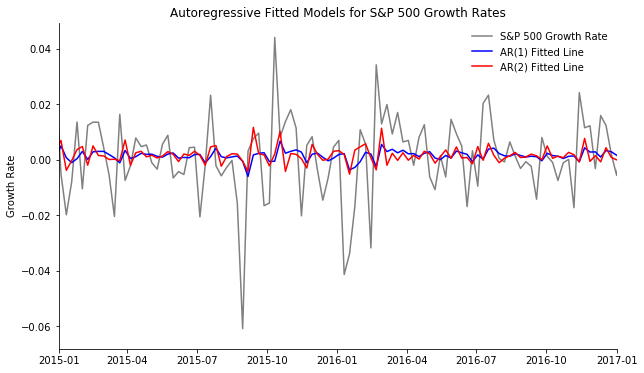

In [228]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sp.index, sp.logdiff, color="gray", label="S&P 500 Growth Rate")
ax.plot(sp_ar1.fittedvalues, color="blue", label="AR(1) Fitted Line")
ax.plot(sp_araic.fittedvalues, color="red", label="AR({0}) Fitted Line".format(sp_araic.k_ar))
sea.despine(ax=ax)
ax.legend(frameon=False)
ax.set_ylabel("Growth Rate")
ax.set_title("Autoregressive Fitted Models for S&P 500 Growth Rates")
ax.set_xlim(left="2015/1/1", right="2017/1/1")

plt.show()